## **HUMAN IN THE LOOP**


In [1]:
from langchain_ollama import ChatOllama
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated, List
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt, Command

In [2]:
class AgentState(TypedDict):
    messages: Annotated[List, add_messages]

In [3]:
# tool
@tool
def get_stock_price(company: str) -> str:
    """
    Returns the current stock price for the given company.
    Args:
        company (str): The company name to look up.
    returns:
        The current stock price.
    """
    return {
        "Microsoft": 423.37,
        "Apple": 269.96,
        "Google": 344.90,
        "Amazon": 242.96,
        "Nvidia": 185.61,
        "Meta": 706.41,
    }.get(company.capitalize(), "Company not found")


@tool
def buy_stocks(company: str, quantity: int, total_price: float) -> str:
    """
    Buys a specified quantity of stocks for the given company.
    Args:
        company (str): The company name to buy stocks from.
        quantity (int): The number of stocks to buy.
        total_price (float): The total price of the stocks to buy.

    returns:
        Confirmation message of the purchase.
    """

    decision = interrupt(
        f"Do you want to buy {quantity} shares of {company} for ${total_price}? (yes/no)")

    if decision.lower() == "yes":
        return f"You bought {quantity} shares of {company} for ${total_price}."

    else:
        return "Purchase cancelled."


@tool
def sell_stocks(company: str, quantity: int, total_price: float) -> str:
    """
    Sells a specified quantity of stocks for the given company.
    args:
        company (str): The company name to sell stocks from.
        quantity (int): The number of stocks to sell.
        total_price (float): The total price of the stocks to sell.

    returns:
        Confirmation message of the sold stocks.
    """
    decision = interrupt(
        f"Do you want to sell {quantity} shares of {company} for ${total_price}? (yes/no)")

    if decision.lower() == "yes":
        return f"You sold {quantity} shares of {company} for ${total_price}."

    else:
        return "Sale cancelled."


tools = [get_stock_price, buy_stocks, sell_stocks]

In [4]:
llm = ChatOllama(model="deepseek-v3.1:671b-cloud").bind_tools(tools=tools)

In [5]:
def agent(state: AgentState) -> AgentState:
    response = llm.invoke(state["messages"])

    return {"messages": [response]}

In [6]:
memory = MemorySaver()

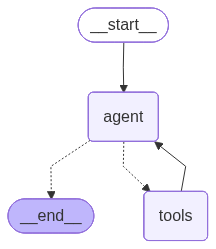

In [7]:
graph = StateGraph(AgentState)

graph.add_node("agent", agent)

tools = ToolNode(tools=tools)
graph.add_node("tools", tools)

graph.add_edge(START, "agent")
graph.add_conditional_edges("agent", tools_condition)

graph.add_edge("tools", "agent")

app = graph.compile(checkpointer=memory)
app

In [8]:
config = {
    "configurable": {"thread_id": "thread_1"},
}

In [ ]:
while True:

    # normal user query
    user_input = input("\nEnter your query: ")
    if "exit" in user_input.lower():
        break

    response1 = app.invoke({
        "messages": [{"role": "user", "content": user_input}]
    }, config=config)

    isinterrupt = response1.get("__interrupt__")
    # print("\nInterrupt status:", isinterrupt)

    # human in the loop decision
    if isinterrupt:
        print(response1["messages"][-1].content)

        decision = input("\nDo you want to Proceed (yes/no): ")

        response2 = app.invoke(Command(resume=decision), config=config)

        print(response2["messages"][-1].content)

    else:
        print(response1["messages"][-1].content)

print("\nSession ended.")

Hello! How can I help you today? I can assist you with checking stock prices, buying stocks, or selling stocks. What would you like to do?
Apple (AAPL) is currently trading at $269.96 per share. This appears to be performing quite well! The stock price is at a decent level, though I'd recommend checking additional market data like today's price movement (up/down) and volume for a more complete picture of today's performance.

Would you like to buy or sell Apple shares, or do you need any other information?
Here are the current prices:
- Apple: $269.96 per share
- Meta: $706.41 per share

For your purchase:
- 10 shares of Apple: 10 × $269.96 = $2,699.60
- 15 shares of Meta: 15 × $706.41 = $10,596.15
- Total investment: $13,295.75

I'll proceed with buying both sets of shares for you:
Here are the current prices:
- Apple: $269.96 per share
- Meta: $706.41 per share

For your purchase:
- 10 shares of Apple: 10 × $269.96 = $2,699.60
- 15 shares of Meta: 15 × $706.41 = $10,596.15
- Total in